# Inventory Monitoring at Distribution Centers
## Amazon Bin Image Dataset Challenge

Distribution centers often use robots to move objects as a part of their operations. Objects are carried in bins which can contain multiple objects. In this project, we will build a deep learning model to count the number of obkect in each bin. It is a real-world example as distribution centers would benefit from tracking inventory with correct number of items in delivery consigments.

Our dataset is from Open Data on AWS called Amazon Bin Image Dataset. It contains over 500,000 images and metadata from bins of a pod in an operating Amazon Fulfillment Center. The bin images in this dataset are captured as robot units carry pods during Amazon Fulfillment Center operations.

In the dataset, we have metadata on top of the images. To be able to build a model, we had to divide images into labelled folders. However, Udacity provided us a json file that already labeled 2% of the dataset (10441 images). We have 5 folders, named as 1,2,3,4,5 which are our classes showing how many objects exist in each bin. The main purpose of this project is to demonstrate how we could build end-to-end Machine Learning pipeline. Therefore, having smaller dataset will be convenient considering the costs that would raise during AWS services utilization.

In [2]:
# Installing packages that we might need
import sys
!{sys.executable} -m pip install smdebug torch torchvision tqdm

In [1]:
# Importing any packages that we might need
import os
import boto3
import sagemaker
from sagemaker.tuner import CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig, ProfilerRule, rule_configs, ProfilerConfig, FrameworkProfile
from sagemaker.analytics import HyperparameterTuningJobAnalytics

## Data Preparation

The cell below creates a folder called `train_data`, downloads training data and arranges it in subfolders. Each of these subfolders contain images where the number of objects is equal to the name of the folder. For instance, all images in folder `1` has images with 1 object in them. Images are not divided into training, testing or validation sets. For more samples, you can always download more data (instructions for that can be found [here](https://registry.opendata.aws/amazon-bin-imagery/)).

In [13]:
import json
from tqdm import tqdm

def download_and_arrange_data():
    s3_client = boto3.client('s3')

    with open('file_list.json', 'r') as f:
        d=json.load(f)

    for k, v in d.items():
        print(f"Downloading Images with {k} objects")
        directory=os.path.join('train_data', k)
        if not os.path.exists(directory):
            os.makedirs(directory)
        for file_path in tqdm(v):
            file_name=os.path.basename(file_path).split('.')[0]+'.jpg'
            s3_client.download_file('aft-vbi-pds', os.path.join('bin-images', file_name),
                             os.path.join(directory, file_name))

In [12]:
download_and_arrange_data()

  0%|          | 1/1228 [00:00<02:35,  7.87it/s]

  0%|          | 1/2299 [00:00<04:09,  9.21it/s]

  0%|          | 2/2666 [00:00<02:30, 17.71it/s]

  0%|          | 2/2373 [00:00<02:57, 13.33it/s]

  0%|          | 2/1875 [00:00<02:12, 14.15it/s]

100%|██████████| 1875/1875 [02:19<00:00, 13.43it/s]


In [3]:
#Analyzing number of images in each classes
from os import listdir
import os.path

count = 0
dataset_folder = 'train_data'

for file in os.listdir(dataset_folder):
    path = os.path.join(dataset_folder, file)
    number = len(os.listdir(path))
    print(f'Number of images with the label of "{file}": {number}')
    count += number
print(f'\nNumber of images in total: {count}')
total_images = count

Number of images with the label of "2": 2299
Number of images with the label of "4": 2373
Number of images with the label of "1": 1229
Number of images with the label of "5": 1875
Number of images with the label of "3": 2666

Number of images in total: 10442


## Train-Test-Validation Split

In [4]:
# We are preparing our folders for train-test-validation split

train_test_val_split = ['train','validation','test']
labels =['1','2','3','4','5']

new_folder_dataset = 'amazon_images'

if not os.path.exists(new_folder_dataset):
    os.makedirs(new_folder_dataset)
    print(f'Successfully created a new folder named "{new_folder_dataset}"')

for folder in train_test_val_split:
    
    if not os.path.exists(os.path.join(new_folder_dataset, folder)):
        os.makedirs(os.path.join(new_folder_dataset, folder))
        print(f'Successfully created the path of "{os.path.join(new_folder_dataset, folder)}"')
        
    for label in labels:
        path = os.path.join(new_folder_dataset, folder, label)
        if not os.path.exists(path):
            os.makedirs(path)
            print(f'Successfully created the path of "{path}"')
            
# Useful method to delete a folder with files inside
# import shutil
# shutil.rmtree('bin_images')

Successfully created a new folder named "amazon_images"
Successfully created the path of "amazon_images/train"
Successfully created the path of "amazon_images/train/1"
Successfully created the path of "amazon_images/train/2"
Successfully created the path of "amazon_images/train/3"
Successfully created the path of "amazon_images/train/4"
Successfully created the path of "amazon_images/train/5"
Successfully created the path of "amazon_images/validation"
Successfully created the path of "amazon_images/validation/1"
Successfully created the path of "amazon_images/validation/2"
Successfully created the path of "amazon_images/validation/3"
Successfully created the path of "amazon_images/validation/4"
Successfully created the path of "amazon_images/validation/5"
Successfully created the path of "amazon_images/test"
Successfully created the path of "amazon_images/test/1"
Successfully created the path of "amazon_images/test/2"
Successfully created the path of "amazon_images/test/3"
Successfully

##### As we are working with only 2% of the dataset, I wanted to leverage the data as much as I could to better train. 
- Training: 80%
- Testing: 10%
- Validation: 10%

We can also do resizing process in this step. In this way, all images would be in the same format which is critical for training. There are several transform methods that we could achieve this in later stages and I wanted to learn how to resize images manually here as well. However, you can see that it is commented out as new images will not come with 224,224 sizes, our endpoint should be able to deal with this transform.

In [6]:
from PIL import Image
import shutil

train_ratio = 0.8
test_ratio = (1 - train_ratio)/2
validation_ratio = (1 - train_ratio)/2
    
for label in os.listdir(dataset_folder):
    
    path = os.path.join(dataset_folder, label)
    dataset = (os.listdir(path))
    dataset_len = len((os.listdir(path)))
    
    train_len = round(dataset_len * train_ratio)
    train_list = dataset[:train_len]
    
    test_len = round(dataset_len * test_ratio)
    test_list = dataset[train_len:train_len+test_len]
    
    validation_len = round(dataset_len * validation_ratio)
    validation_list = dataset[train_len+test_len:]
    
    list_dictionary = {'train': train_list,
                       'test': test_list,
                       'validation': validation_list}
    
    print("Label number is: " + label)
    
    for folder in train_test_val_split:
#         print('Resizing of the images is starting...')
        print(f'Saving the files to {new_folder_dataset}/{folder} folder\n')
        for file in list_dictionary[folder]:
            path = os.path.join(dataset_folder, label, file)
            if 'ipynb' not in path:
                
# This can be used to resize images in this step

#                 img = Image.open(path).convert('RGB')
#                 resized_img = img.resize((224,224),Image.BILINEAR)
#                 image_path = os.path.join(new_folder_dataset, folder, label, file)     
#                 resized_img.save(image_path)

                copy = os.path.join(dataset_folder, label, file)
                paste = os.path.join(new_folder_dataset, folder, label)
                shutil.copy(copy, paste)

print('\nSaving process has been completed.')

Label number is: 2
Saving the files to amazon_images/train folder

Saving the files to amazon_images/validation folder

Saving the files to amazon_images/test folder

Label number is: 4
Saving the files to amazon_images/train folder

Saving the files to amazon_images/validation folder

Saving the files to amazon_images/test folder

Label number is: 1
Saving the files to amazon_images/train folder

Saving the files to amazon_images/validation folder

Saving the files to amazon_images/test folder

Label number is: 5
Saving the files to amazon_images/train folder

Saving the files to amazon_images/validation folder

Saving the files to amazon_images/test folder

Label number is: 3
Saving the files to amazon_images/train folder

Saving the files to amazon_images/validation folder

Saving the files to amazon_images/test folder


Saving process has been completed.


In [7]:
# Analysis of how many images in each split per classes
analysis_list = []
for folder in os.listdir(new_folder_dataset):
    for label in os.listdir(os.path.join(new_folder_dataset, folder)):
        path = os.path.join(new_folder_dataset, folder, label)
        number = len(os.listdir(path))
        print(f'Number of Images in {folder}-split with the label of "{label}": {number}')
        analysis_list.append(number)

Number of Images in test-split with the label of "2": 230
Number of Images in test-split with the label of "4": 237
Number of Images in test-split with the label of "1": 123
Number of Images in test-split with the label of "5": 187
Number of Images in test-split with the label of "3": 267
Number of Images in validation-split with the label of "2": 230
Number of Images in validation-split with the label of "4": 238
Number of Images in validation-split with the label of "1": 122
Number of Images in validation-split with the label of "5": 188
Number of Images in validation-split with the label of "3": 266
Number of Images in train-split with the label of "2": 1839
Number of Images in train-split with the label of "4": 1898
Number of Images in train-split with the label of "1": 983
Number of Images in train-split with the label of "5": 1500
Number of Images in train-split with the label of "3": 2133


In [8]:
# Visualize the split by utilizing dataframes
import numpy as np
import pandas as pd
analysis_array = np.array(analysis_list).reshape(3,5)
df = pd.DataFrame(analysis_array, index=['Test', 'Validation', 'Train'], 
                  columns=['Label: 2','Label: 4','Label: 1','Label: 5','Label: 3'],
                 )
df

,Label: 2,Label: 4,Label: 1,Label: 5,Label: 3
Test,230,237,123,187,267
Validation,230,238,122,188,266
Train,1839,1898,983,1500,2133


We would like to check one of the images to understand the differences in sizes. It proves that we will need to resize the images during transforming process to make all of them 224,224.

Amazon Bin Photo:


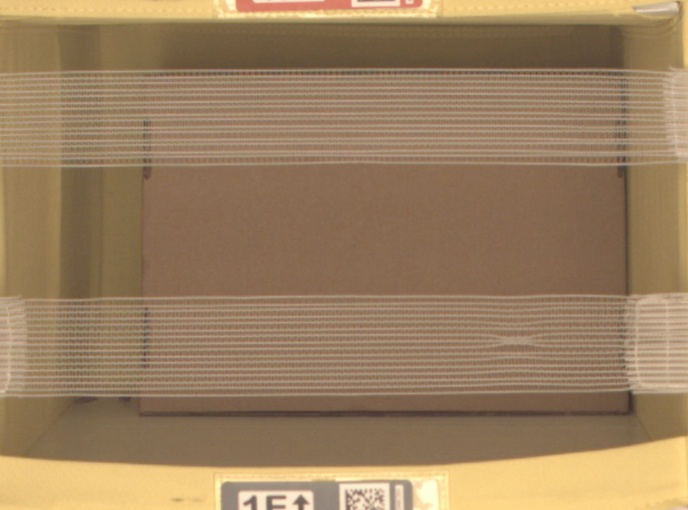

Amazon Bin Photo:


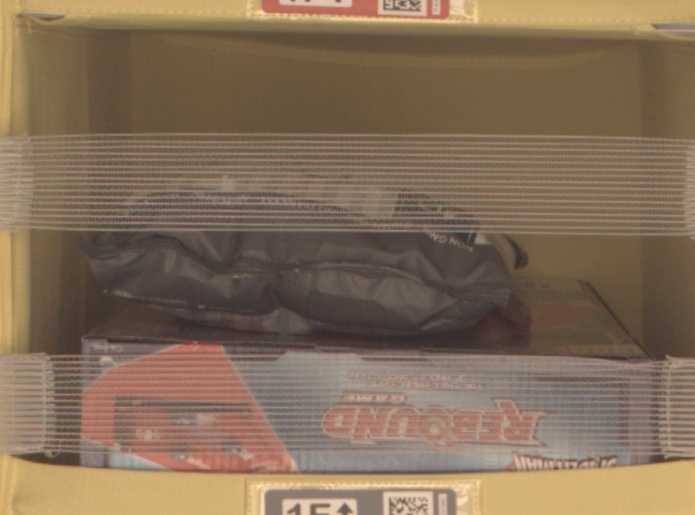

Amazon Bin Photo:


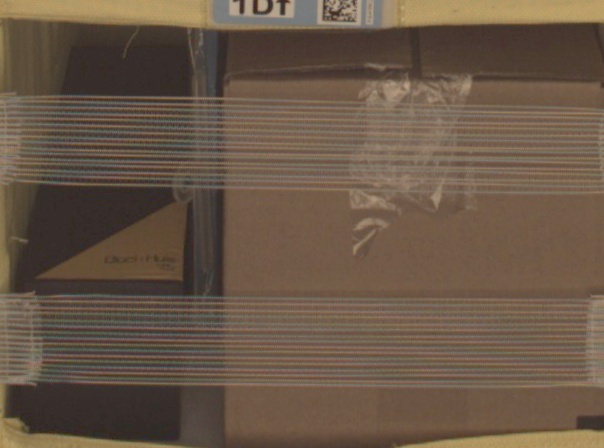

Amazon Bin Photo:


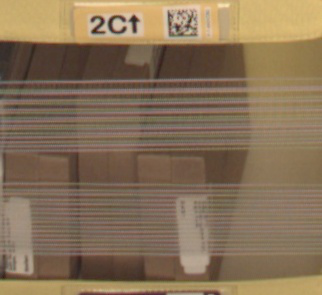

Amazon Bin Photo:


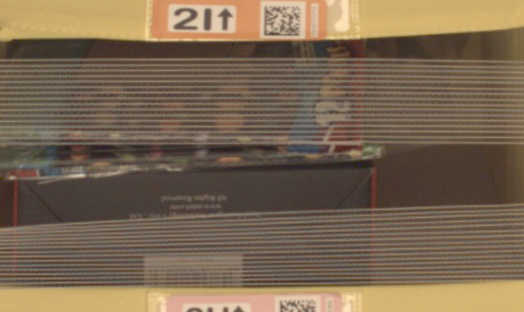

In [11]:
files = [
    'amazon_images/test/1/00035.jpg',
    'amazon_images/test/2/01623.jpg',
    'amazon_images/test/3/00350.jpg',
    'amazon_images/test/4/00005.jpg',
    'amazon_images/test/5/00155.jpg',
    ]
    
for file in files:
    target_str = 'test/'    
    img = Image.open(file)
    print('Amazon Bin Photo:')
    display(img)

In [12]:
# Now it is time to upload our folder to Amazon S3
bucket = 'aws-udacity-capstone'
prefix = 'dataset_images'
# !aws s3 cp amazon_images s3://aws-udacity-capstone/ --recursive #alternative
session = sagemaker.session.Session()
upload = session.upload_data(path='amazon_images', bucket=bucket, key_prefix=prefix) #this method is considerably slower in this example

## Model Training

### Hyperparameter Tuning
Throughout this course, I learned how convenient it is to run a hyperparameter tuning job via Sagemaker. I chose two parameters to tune:
- Learning Rate between (0.001 and 0.1) as continuous
- Batch Size between (32, 64, 128) as categorical parameter

I personally don't have much experience with hyperparameter tuning, that's why it is great to be able to trust Sagemaker with objective metric to find the best ones. I did not want to increase values further to avoid further increasing the training duration due to cost concerns

In [13]:
role = get_execution_role()

hyperparameter_ranges = {
    "learning_rate": ContinuousParameter(0.001, 0.1),
    "batch_size": CategoricalParameter([32, 64, 128]),
}

objective_metric_name = "Test Loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "Test Loss", "Regex": "Testing Loss: ([0-9\\.]+)"}]

In [14]:
# My training estimator - I tried both instances types, w and w/o GPU. ml.g4dn.xlarge was two times faster than ml.m5.2xlarge. 
# To be able leverage parallel jobs, I went for ml.5.2xlarge as I only have one GPU instance

estimator = PyTorch(
    entry_point="train_hpo.py",
    role=role,
    framework_version="1.8.0",
    instance_count=1,
#     instance_type="ml.g4dn.xlarge",
    instance_type="ml.m5.2xlarge",
    py_version='py3'
)

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=3,
    max_parallel_jobs=3,
    objective_type=objective_type
)

In [113]:
# This is another method which is common to pass environmental parameters. I felt more comfortable with the second approach

# input_data = 's3://aws-udacity-capstone/dataset_images/'
# tuner.fit(   
#     {
#     'train': input_data + 'train',
#     'test': input_data + 'test',
#     'validation': input_data + 'validation'
#     }
# )

In [16]:
# Fit your estimator
os.environ['SM_CHANNEL_TRAIN']='s3://aws-udacity-capstone/dataset_images/'
os.environ['SM_MODEL_DIR']='s3://aws-udacity-capstone/model/'
os.environ['SM_OUTPUT_DATA_DIR']='s3://aws-udacity-capstone/output/'
tuner.fit({"train": "s3://aws-udacity-capstone/dataset_images/"})

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................!


In [17]:
# We identify the best training job with its parameters. These can be seen in the training section of the sagemaker under logs
best_estimator = tuner.best_estimator() 
best_estimator._current_job_name
best_estimator.hyperparameters()


2022-07-06 08:24:08 Starting - Preparing the instances for training
2022-07-06 08:24:08 Downloading - Downloading input data
2022-07-06 08:24:08 Training - Training image download completed. Training in progress.
2022-07-06 08:24:08 Uploading - Uploading generated training model
2022-07-06 08:24:08 Completed - Training job completed


{'_tuning_objective_metric': '"Test Loss"',
 'batch_size': '"32"',
 'learning_rate': '0.02373708521069103',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2022-07-06-07-26-14-153"',
 'sagemaker_program': '"train_hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-678464824168/pytorch-training-2022-07-06-07-26-14-153/source/sourcedir.tar.gz"'}

In [18]:
# we assign best hyperparameters so we could directly put them in the next training
best_lr = float(best_estimator.hyperparameters()['learning_rate'])
best_batch_size = int(best_estimator.hyperparameters()['batch_size'].replace('"', '')) 
# it addes "" so we remove it from batch size

print(f'Best Learning Rate: {best_lr}')
print(f'Best Batch Size: {best_batch_size}')

Best Learning Rate: 0.02373708521069103
Best Batch Size: 32


In [19]:
best_estimator._current_job_name

'pytorch-training-220706-0726-001-df310e90'

In [20]:
#It is nice visualization for categorical values that are used in hyperparameter tunning. We can see the duration, final objective value and more details.
exp = HyperparameterTuningJobAnalytics(
  hyperparameter_tuning_job_name='pytorch-training-220706-0726')

jobs = exp.dataframe()

jobs.sort_values('FinalObjectiveValue', ascending=0)

,batch_size,learning_rate,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
0,"""64""",0.093646,pytorch-training-220706-0726-003-ac1a62ea,Completed,1.577682,2022-07-06 07:27:43+00:00,2022-07-06 07:59:22+00:00,1899.0
1,"""64""",0.006368,pytorch-training-220706-0726-002-f3f461d4,Completed,1.521899,2022-07-06 07:27:41+00:00,2022-07-06 08:25:47+00:00,3486.0
2,"""32""",0.023737,pytorch-training-220706-0726-001-df310e90,Completed,1.453767,2022-07-06 07:27:37+00:00,2022-07-06 08:24:08+00:00,3391.0


### Model Profiling and Debugging
It was optional but I wanted to use what I learned from previous training to get debugging and profiling insights.

In [22]:
# TODO: Set up debugging and profiling rules and hooks
from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig, ProfilerRule, rule_configs, ProfilerConfig, FrameworkProfile

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)

# debugger configuration above was overwritten by profiler config and giving only 3 values for the plot
# due to interval of 500, so I changed it in aligned with mentor suggestions

collection_configs = [
    CollectionConfig(
        name="custom_losses", # it was giving error with normal "losses" name due to duplicate
        parameters={
            "include_regex": "CrossEntropyLoss_output_0",
            "train.save_interval": "10",
            "eval.save_interval": "1"
        }
    )
]

debugger_config = DebuggerHookConfig(
    collection_configs=collection_configs
)

hyperparameters = {"learning_rate": best_lr, 'batch_size': best_batch_size} #assigning best hyperparameters

rules = [
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport())
]

In [27]:
hyperparameters

{'learning_rate': 0.02373708521069103,
 'batch_size': 32,
 'sagemaker_submit_directory': 's3://sagemaker-us-east-1-678464824168/pytorch-training-2022-07-06-08-32-31-924/source/sourcedir.tar.gz',
 'sagemaker_program': 'finetuner.py',
 'sagemaker_container_log_level': 20,
 'sagemaker_job_name': 'pytorch-training-2022-07-06-08-32-31-924',
 'sagemaker_region': 'us-east-1'}

In [23]:
# Create another estimator to fit with a new finetuner entry point. This one has "hook"s to calculate debugging and profiling insights.
estimator = PyTorch(
    entry_point="finetuner.py",
    role=role,
    hyperparameters=hyperparameters,
    framework_version="1.8.0",
    instance_count=1,
    instance_type="ml.g4dn.xlarge",
    py_version='py3',
    rules = rules,
    debugger_hook_config=debugger_config,
    profiler_config=profiler_config
)

In [24]:
# Same fitting method
os.environ['SM_CHANNEL_TRAIN']='s3://aws-udacity-capstone/dataset_images/'
os.environ['SM_MODEL_DIR']='s3://aws-udacity-capstone/model_finetuned/'
os.environ['SM_OUTPUT_DATA_DIR']='s3://aws-udacity-capstone/output_finetuned/'
estimator.fit({"train": "s3://aws-udacity-capstone/dataset_images/"})

2022-07-06 08:32:32 Starting - Starting the training job...
2022-07-06 08:32:59 Starting - Preparing the instances for trainingLossNotDecreasing: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
.........
2022-07-06 08:34:19 Downloading - Downloading input data.........
2022-07-06 08:36:00 Training - Downloading the training image....................bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-07-06 08:39:13,172 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-07-06 08:39:13,196 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-07-06 08:39:13,204 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-07-06 08:39:13,825 sagemaker-training-toolkit INFO     Invoking user script
Training Env:
{
    "additional_framework_parameters": {},
    "channel_input_dirs": {
        "train": "/o

In [26]:
# Before visualizing, we could see how many tensor we recorded.
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys
trial = create_trial(estimator.latest_job_debugger_artifacts_path())
trial.tensor_names()
trial.tensor('CrossEntropyLoss_output_0').values()

[2022-07-06 09:27:12.391 ip-172-16-114-223:1787 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-07-06 09:27:12.448 ip-172-16-114-223:1787 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-678464824168/pytorch-training-2022-07-06-08-32-31-924/debug-output


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


[2022-07-06 09:27:12.960 ip-172-16-114-223:1787 WARNING s3handler.py:183] Encountered the exception An error occurred while reading from response stream: ('Connection broken: IncompleteRead(0 bytes read, 232 more expected)', IncompleteRead(0 bytes read, 232 more expected)) while reading s3://sagemaker-us-east-1-678464824168/pytorch-training-2022-07-06-08-32-31-924/debug-output/index/000000000/000000000100_worker_0.json . Will retry now
[2022-07-06 09:27:16.070 ip-172-16-114-223:1787 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2022-07-06 09:27:17.089 ip-172-16-114-223:1787 INFO trial.py:210] Loaded all steps


{0: array(1.6178849, dtype=float32),
 10: array(1.5477434, dtype=float32),
 20: array(1.5793959, dtype=float32),
 30: array(1.6274017, dtype=float32),
 40: array(1.5457376, dtype=float32),
 50: array(1.5154121, dtype=float32),
 60: array(1.5834564, dtype=float32),
 70: array(1.5372676, dtype=float32),
 80: array(1.5957073, dtype=float32),
 90: array(1.5959044, dtype=float32),
 100: array(1.5570245, dtype=float32),
 110: array(1.6307358, dtype=float32),
 120: array(1.559107, dtype=float32),
 130: array(1.5703228, dtype=float32),
 140: array(1.6162467, dtype=float32),
 150: array(1.5660394, dtype=float32),
 160: array(1.5439701, dtype=float32),
 170: array(1.5522039, dtype=float32),
 180: array(1.5557898, dtype=float32),
 190: array(1.5285667, dtype=float32),
 200: array(1.6205827, dtype=float32),
 210: array(1.4999455, dtype=float32),
 220: array(1.5167357, dtype=float32),
 230: array(1.5184435, dtype=float32),
 240: array(1.4476113, dtype=float32),
 250: array(1.4961997, dtype=float32)

Tensors Train: 53
Tensors Valid:  99
TRAIN data loading
VALID data loading


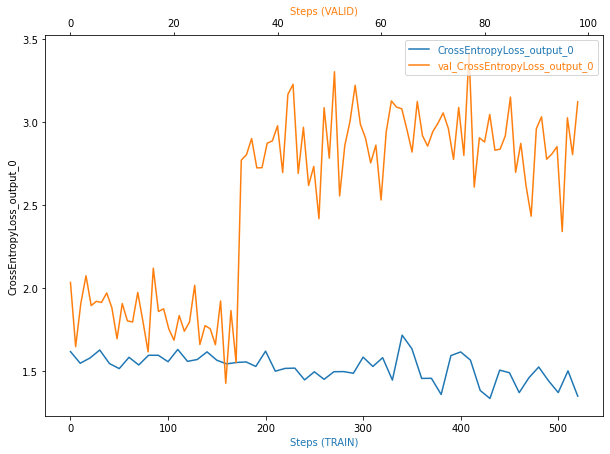

In [28]:
#Plotting a debugging output

print(f'Tensors Train: {len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN))}')
print(f'Tensors Valid:  {len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.EVAL))}')

def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot

def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("TRAIN data loading")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("VALID data loading")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (VALID)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()
    
plot_tensor(trial, "CrossEntropyLoss_output_0")

In [87]:
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob
tj = TrainingJob(job_name, region)
tj.wait_for_sys_profiling_data_to_be_available()

ProfilerConfig:{'S3OutputPath': 's3://sagemaker-us-east-1-678464824168/', 'ProfilingIntervalInMilliseconds': 500, 'ProfilingParameters': {'DataloaderProfilingConfig': '{"StartStep": 0, "NumSteps": 10, "MetricsRegex": ".*", }', 'DetailedProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }', 'FileOpenFailThreshold': '50', 'HorovodProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }', 'LocalPath': '/opt/ml/output/profiler', 'PythonProfilingConfig': '{"StartStep": 0, "NumSteps": 10, "ProfilerName": "cprofile", "cProfileTimer": "total_time", }', 'RotateFileCloseIntervalInSeconds': '60', 'RotateMaxFileSizeInBytes': '10485760', 'SMDataParallelProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }'}}
s3 path:s3://sagemaker-us-east-1-678464824168/pytorch-training-2022-07-05-21-06-18-171/profiler-output


Profiler data from system is available


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


In [82]:
# TODO: Display the profiler output
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"You will find the profiler report in {rule_output_path}")

You will find the profiler report in s3://sagemaker-us-east-1-678464824168/pytorch-training-2022-07-05-21-06-18-171/rule-output


In [83]:
! aws s3 ls {rule_output_path} --recursive

2022-07-05 21:15:57     389848 pytorch-training-2022-07-05-21-06-18-171/rule-output/ProfilerReport/profiler-output/profiler-report.html
2022-07-05 21:15:57     239947 pytorch-training-2022-07-05-21-06-18-171/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2022-07-05 21:15:52        191 pytorch-training-2022-07-05-21-06-18-171/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2022-07-05 21:15:52       7426 pytorch-training-2022-07-05-21-06-18-171/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2022-07-05 21:15:52       2141 pytorch-training-2022-07-05-21-06-18-171/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2022-07-05 21:15:52        129 pytorch-training-2022-07-05-21-06-18-171/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2022-07-05 21:15:52       3793 pytorch-training-2022-07-05-21-06-18-171/rule-output/ProfilerReport/profiler-output/profiler-re

In [84]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-678464824168/pytorch-training-2022-07-05-21-06-18-171/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json to ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
download: s3://sagemaker-us-east-1-678464824168/pytorch-training-2022-07-05-21-06-18-171/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json to ProfilerReport/profiler-output/profiler-reports/Dataloader.json
download: s3://sagemaker-us-east-1-678464824168/pytorch-training-2022-07-05-21-06-18-171/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to ProfilerReport/profiler-output/profiler-reports/BatchSize.json
download: s3://sagemaker-us-east-1-678464824168/pytorch-training-2022-07-05-21-06-18-171/rule-output/ProfilerReport/profiler-output/profiler-reports/MaxInitializationTime.json to ProfilerReport/profiler-output/profiler-reports/MaxInitializationTime.json
download: s3://sagemaker-us-east-1-67846482416

In [85]:
import os

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

When I run the code below, it makes my jupyter notebook white and does not allow me to see the rest. So keep it here with profiler report as a separate doc.

In [ ]:
import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

### Model Deploying and Querying

In [93]:
# This is the model that I want to deploy which we also used in debugging/profiling
model_location = 's3://sagemaker-us-east-1-678464824168/pytorch-training-2022-07-05-21-06-18-171/output/model.tar.gz'

In [103]:
# Deploy your model to an endpoint
from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()


class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer,
        )

# Another entry point was needed. 
pytorch_model = PyTorchModel(model_data=model_location, 
                             role=role, 
                             entry_point='inference.py',
                             py_version='py3',
                             framework_version='1.8',
                             predictor_cls=ImagePredictor
                            )

In [104]:
# After waiting for a while, you could see the endpoint under sagemaker endpoints.
predictor = pytorch_model.deploy(initial_instance_count=1, instance_type='ml.m5.large')

------!

Amazon Bin Photo:


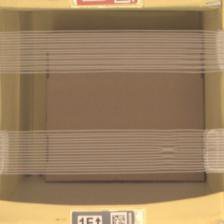

Image Label: 1
ML Prediction: 1
Correct Prediction

Amazon Bin Photo:


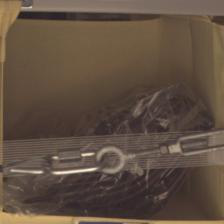

Image Label: 1
ML Prediction: 1
Correct Prediction

Amazon Bin Photo:


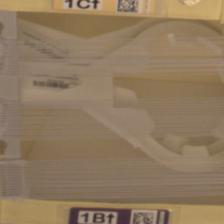

Image Label: 2
ML Prediction: 1
Wrong Prediction

Amazon Bin Photo:


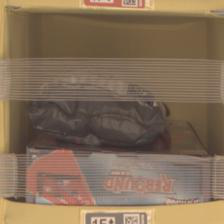

Image Label: 2
ML Prediction: 1
Wrong Prediction

Amazon Bin Photo:


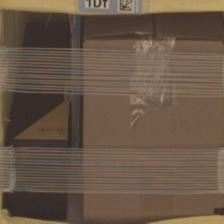

Image Label: 3
ML Prediction: 1
Wrong Prediction

Amazon Bin Photo:


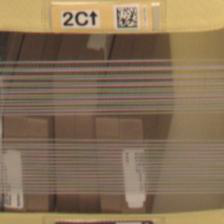

Image Label: 4
ML Prediction: 1
Wrong Prediction

Amazon Bin Photo:


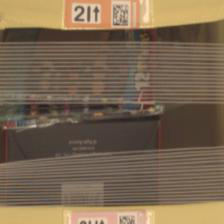

Image Label: 5
ML Prediction: 2
Wrong Prediction



In [112]:
from PIL import Image
import numpy as np

# Manually collected 7 images to deploy and see the results. One of the peer had an useful method where he shared in the feedback channel. 
# I keep using it as in the previous project.

files = [
    'amazon_bin_images/test/1/00035.jpg',
    'amazon_bin_images/test/1/00288.jpg',
    'amazon_bin_images/test/2/00189.jpg',
    'amazon_bin_images/test/2/01623.jpg',
    'amazon_bin_images/test/3/00350.jpg',
    'amazon_bin_images/test/4/00005.jpg',
    'amazon_bin_images/test/5/00155.jpg',

    ]
    
for file in files:
    target_str = 'test/'
    in_pos = file.index(target_str) + len(target_str)
#     print(file)
    label = int(file[in_pos:in_pos+1]) #labels
    
    img = Image.open(file)
    print('Amazon Bin Photo:')
    display(img) # showing the dog pictures
    
    image = open(file, 'rb').read()
    response = predictor.predict(image, initial_args={'ContentType':'image/jpeg'})
    prediction = np.argmax(response[0]) + 1  # prediction
    
    print(f'Image Label: {label}')
    print(f'ML Prediction: {prediction}')
    if label == prediction:
        print("Correct Prediction\n")
    else:
        print("Wrong Prediction\n")

### Cheaper Training and Cost Analysis
**TODO:** Can you perform a cost analysis of your system and then use spot instances to lessen your model training cost?
As this part is optional, I am leaving it for another time to work on it.

In [ ]:
# TODO: Cost Analysis

In [ ]:
# TODO: Train your model using a spot instance

### Multi-Instance Training
**TODO:** Can you train your model on multiple instances?

In [ ]:
# TODO: Train your model on Multiple Instances